In [47]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [48]:
# Read train and test csv files
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [49]:
# to have an overlook of data
train_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
# replacing nan values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

### Converting columns with string values to integers

In [51]:
def convert_str_to_num(df, column, saved_dict):
    if saved_dict is not None:
        print('using passed entry dict')
        entry_dict = saved_dict
    else:
        print('creating a new entry dict')
        entry_dict = {}
        unique_entries = list(df[column].unique())
        for idx, value in enumerate(unique_entries):
            entry_dict[value if isinstance(value, str) else str(value)] = idx+1
        
    for i in range(len(df)):
        if df[column][i] in entry_dict:
            df[column][i] = entry_dict[df[column][i]]
        else:
            df[column][i] = 0
        
    # for value in entry_dict:
    #  df[column] = df[column].replace(value, entry_dict[value])
    return df, entry_dict

In [52]:
train_df, sex_dict = convert_str_to_num(train_df.copy(), 'Sex', saved_dict=None)
train_df, cabin_dict = convert_str_to_num(train_df.copy(), 'Cabin', saved_dict=None)
train_df, emb_dict = convert_str_to_num(train_df.copy(), 'Embarked', saved_dict=None)

test_df, _ = convert_str_to_num(test_df.copy(), 'Sex', saved_dict=sex_dict)
test_df, _ = convert_str_to_num(test_df.copy(), 'Cabin', saved_dict=cabin_dict)
test_df, _ = convert_str_to_num(test_df.copy(), 'Embarked', saved_dict=emb_dict)

creating a new entry dict
creating a new entry dict


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


creating a new entry dict
using passed entry dict
using passed entry dict
using passed entry dict


### Min Max Normalization

In [53]:
def normalize_column_min_max(df, column, minimum=None, maximum=None):
    if minimum is None or maximum is None:
        print("creating new min max ")
        minimum = df[column].min()
        maximum = df[column].max()
    else:
        print("using passed values")
    
    df[column] = (df[column]-minimum)/(maximum-minimum)
    return df, minimum, maximum

In [54]:
train_df, p_min, p_max = normalize_column_min_max(df=train_df.copy(), column='Pclass')
train_df, a_min, a_max = normalize_column_min_max(df=train_df.copy(), column='Age')
train_df, c_min, c_max = normalize_column_min_max(df=train_df.copy(), column='Cabin')
train_df, e_min, e_max = normalize_column_min_max(df=train_df.copy(), column='Embarked')

test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Pclass', minimum=p_min, maximum=p_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Age', minimum=a_min, maximum=a_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Cabin', minimum=c_min, maximum=c_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Embarked', minimum=e_min, maximum=e_max)

creating new min max 
creating new min max 
creating new min max 
creating new min max 
using passed values
using passed values
using passed values
using passed values


### Create train dataset and labels

In [55]:
input_columns = ['Pclass', 'Sex', 'Age', 'Cabin', 'Embarked']
train_input = []
train_labels = []

for _, row in train_df.iterrows():
    input_ = []
    train_labels.append([row['Survived']])
    for column in input_columns:
        input_.append(row[column])
    input_ = np.array(input_)
    # input_ = input_.reshape(input_.size, 1)
    train_input.append(input_)

In [56]:
train_input_shuffled, train_labels_shuffled = shuffle(train_input, train_labels)

train_input_shuffled = np.array(train_input_shuffled)
train_labels_shuffled = np.array(train_labels_shuffled)

### Define a simple DNN architecture

In [63]:
model = Sequential()
model.add(layers.Dense(8, input_shape=(None, 5), activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [64]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, None, 8)           48        
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 8)           0         
_________________________________________________________________
dense_16 (Dense)             (None, None, 32)          288       
_________________________________________________________________
dense_17 (Dense)             (None, None, 1)           33        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


### Train

In [66]:
history = model.fit(train_input_shuffled, train_labels_shuffled, validation_split=0.1, epochs=25, batch_size=8, validation_batch_size=1)

Epoch 1/25
101/101 [==============================] - 1s 8ms/step - loss: 0.6950 - accuracy: 0.5668 - val_loss: 0.6505 - val_accuracy: 0.6444
Epoch 2/25
101/101 [==============================] - 1s 5ms/step - loss: 0.6614 - accuracy: 0.6454 - val_loss: 0.6272 - val_accuracy: 0.7000
Epoch 3/25
101/101 [==============================] - 1s 5ms/step - loss: 0.6500 - accuracy: 0.6492 - val_loss: 0.6049 - val_accuracy: 0.7444
Epoch 4/25
101/101 [==============================] - 1s 6ms/step - loss: 0.6205 - accuracy: 0.7166 - val_loss: 0.5671 - val_accuracy: 0.7444
Epoch 5/25
101/101 [==============================] - 1s 6ms/step - loss: 0.6046 - accuracy: 0.7054 - val_loss: 0.5400 - val_accuracy: 0.7556
Epoch 6/25
101/101 [==============================] - 1s 5ms/step - loss: 0.5889 - accuracy: 0.7266 - val_loss: 0.5131 - val_accuracy: 0.7667
Epoch 7/25
101/101 [==============================] - 1s 5ms/step - loss: 0.5736 - accuracy: 0.7353 - val_loss: 0.4978 - val_accuracy: 0.7667
Epoch 

### Train and validation charts

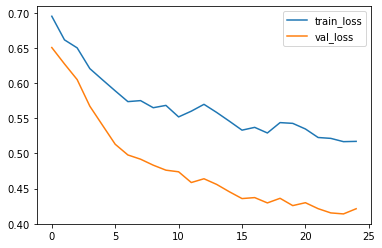

In [67]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

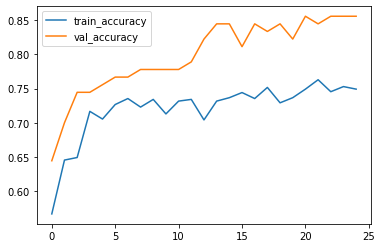

In [68]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Predict

In [74]:
result_dict = {'PassengerId': [], 'Survived': []}

for _, row in test_df.iterrows():
    input_ = []
    for column in input_columns:
        input_.append(row[column])
    input_ = np.array(input_)
    # input_ = input_.reshape(input_.size, 1)
    prediction = model.predict(np.array([input_]))
    survived = 0
    if prediction > 0.5:
        survived = 1
    result_dict['PassengerId'].append(row['PassengerId'])
    result_dict['Survived'].append(survived)

In [75]:
result_df = pd.DataFrame(result_dict)

In [77]:
result_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [78]:
# Dump into a csv file
result_df.to_csv('titanic_predictions.csv', index=False)